## Цель:
__Необходимо обучить модель, которая будет присваивать сообщениям класс (жалоба/вопрос).__

## Задачи:
* сделать первичную обработку и провести эксплораторный анализ данных и описать выводы, полученные на его основе;
* обучить классификатор/классификаторы, обосновать выбор модели/моделей;
* оценить качество классификации;
* описать проблемы, возникшие при выполнении задания, сделать рекомендации по улучшению модели/обогащению данных.

## Этапы работы:
1. [Препроцессинг](#section_id_0)
2. [Эксплораторный анализ данных](#section_id_1)
3. [Обучение классификаторов](#section_id_2)
4. [Оценка качества полученных моделей](#section_id_3)
5. [Выводы по классификаторам](#section_id_4)
6. [Описание возникших проблем и возможные пути дальнейшей работы с данными](#section_id_5)

## Препроцессинг <a id='section_id_0'></a>

In [1]:
# 0.1 Введем библиотеки
import pandas as pd
import numpy as np
import regex
import re
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.corpus import stopwords
import stop_words
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm

from randan.descriptive_statistics import NominalStatistics
from randan.bivariate_association import Crosstab
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, Range1d
from bokeh.layouts import column
from bokeh.palettes import all_palettes

from wordcloud import WordCloud

import umap

from collections import Counter

In [2]:
# 0.2 ввод датафрейма
df1 = pd.read_excel('Data_scientist_NLP_данные.xlsx')
#df1 = df1.head(100) # для теста кода
df1['text'] = df1['Текст'].astype(str).str.zfill(6)
df1

,Дата,Категория,Тема,Муниципалитет,Текст,text
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


In [3]:
# 1.1 токенизируем текстовые данные
regexp = RegexpTokenizer('\w+')

df1['text_token']=df1['text'].apply(regexp.tokenize)
df1.head(10)

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...,"[Вид, из, окна, потрясающий, пр, С, Юлаева, на..."
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс...","[id294938415, bp, 88767010_4, Αнастасия, Здрав..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...,"[club53367440, bp, 53367440_121743, Министерст..."
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,'Здравствуйте когда будет выплата ДВ?,"[Здравствуйте, когда, будет, выплата, ДВ]"
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ...","[Девочки, всем, привет, у, меня, такой, вопрос..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,'Когда будет приведён в порядок пруд в центре ...,"[Когда, будет, приведён, в, порядок, пруд, в, ..."
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,'Обращаюсь от имени одиноких престарелых людей...,"[Обращаюсь, от, имени, одиноких, престарелых, ..."
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","[Добрый, день, Игорь, Юрьевич, С, 4, марта, 20..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,'А про Камызякский район забыли?,"[А, про, Камызякский, район, забыли]"
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...","'Здравствуйте!Скажите пожалуйста,правда ли,что...","[Здравствуйте, Скажите, пожалуйста, правда, ли..."


In [4]:
# 1.2
df1['text_token'] = df1['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df1.head(10)

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...,Вид окна потрясающий Юлаева напротив Юбилейной...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс...",id294938415 88767010_4 Αнастасия Здравствуйте ...
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...,club53367440 53367440_121743 Министерство здра...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,'Здравствуйте когда будет выплата ДВ?,Здравствуйте когда будет выплата
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ...",Девочки всем привет меня такой вопрос получила...
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,'Когда будет приведён в порядок пруд в центре ...,Когда будет приведён порядок пруд центре Ивни ...
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,'Обращаюсь от имени одиноких престарелых людей...,Обращаюсь имени одиноких престарелых людей жит...
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",Добрый день Игорь Юрьевич марта 2022 года пере...
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,'А про Камызякский район забыли?,про Камызякский район забыли
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...","'Здравствуйте!Скажите пожалуйста,правда ли,что...",Здравствуйте Скажите пожалуйста правда что теп...


In [5]:
# 2.1 избавимся от стоп-слов и лемматизируем токены
# создадим функцию для выполнения задачи
stopwords_ru = stopwords.words('russian')
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [6]:
# 2.2 применим лемматизатор
df1['text_lemmatized'] = df1['text_token'].apply(lemmatize)
df1.head(10)

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...,Вид окна потрясающий Юлаева напротив Юбилейной...,"[вид, окно, потрясать, юлаева, напротив, юбиле..."
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс...",id294938415 88767010_4 Αнастасия Здравствуйте ...,"[αнастасия, здравствуйте, подсказать, оспорить..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...,club53367440 53367440_121743 Министерство здра...,"[министерство, здравствуйте, направить, сегодня]"
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,'Здравствуйте когда будет выплата ДВ?,Здравствуйте когда будет выплата,None
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ...",Девочки всем привет меня такой вопрос получила...,"[девочка, весь, привет, вопрос, получить, посо..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,'Когда будет приведён в порядок пруд в центре ...,Когда будет приведён порядок пруд центре Ивни ...,"[когда, привести, порядок, пруд, центр, ивень,..."
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,'Обращаюсь от имени одиноких престарелых людей...,Обращаюсь имени одиноких престарелых людей жит...,"[обращаться, имя, одинокий, престарелый, челов..."
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",Добрый день Игорь Юрьевич марта 2022 года пере...,"[добрый, день, игорь, юриевич, март, год, пере..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,'А про Камызякский район забыли?,про Камызякский район забыли,"[камызякский, район, забыть]"
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...","'Здравствуйте!Скажите пожалуйста,правда ли,что...",Здравствуйте Скажите пожалуйста правда что теп...,"[здравствуйте, сказать, пожалуйста, правда, со..."


In [7]:
# 2.3 избавимся от строк с пропущенными данными
df1.isnull().sum()

Дата                 0
Категория            0
Тема                11
Муниципалитет        0
Текст                0
text                 0
text_token           0
text_lemmatized    699
dtype: int64

In [8]:
df1 = df1.dropna()
df1

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...,Вид окна потрясающий Юлаева напротив Юбилейной...,"[вид, окно, потрясать, юлаева, напротив, юбиле..."
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс...",id294938415 88767010_4 Αнастасия Здравствуйте ...,"[αнастасия, здравствуйте, подсказать, оспорить..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...,club53367440 53367440_121743 Министерство здра...,"[министерство, здравствуйте, направить, сегодня]"
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ...",Девочки всем привет меня такой вопрос получила...,"[девочка, весь, привет, вопрос, получить, посо..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,'Когда будет приведён в порядок пруд в центре ...,Когда будет приведён порядок пруд центре Ивни ...,"[когда, привести, порядок, пруд, центр, ивень,..."
...,...,...,...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...,'Добрый день.Почему подорожала плата за проезд...,Добрый день Почему подорожала плата проезд мар...,"[добрый, день, почему, подорожать, плата, прое..."
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...,'Миасс. Девочки подскажите номер телефона пф о...,Миасс Девочки подскажите номер телефона отдел ...,"[миасс, девочка, подсказать, номер, телефон, о..."
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...,'Здравствуйте почему пришел отказ?<br>db7ced5b...,Здравствуйте почему пришел отказ db7ced5b e829...,"[здравствуйте, почему, прийти, отказ]"
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...,НАЗАД КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБУСЫ,"[назад, какой, интервол, быть, ездить, автобус]"


In [9]:
# возможность сохранения файла с подготовленным текстом
#df1.to_excel('NLP_text_preprocessed.xlsx', sheet_name = 'preprocessed' )

In [10]:
# впоследствии можно будет работать с этого чанка
#df1=pd.read_excel('scp_preprocessed.xlsx', index_col=0)
#df1

## Эксплораторный анализ данных <a id='section_id_1'></a>

### Рассмотрим датасет в целом

In [11]:
# Начнем с описательной статистики
# 3.1 рассмотрим категориальные переменные, относящиеся к характеристикам сообщений пользователей
ns = NominalStatistics(df1, ['Категория','Тема','Муниципалитет'])


NOMINAL STATISTICS SUMMARY
------------------



,N,mode,entropy coef.,quality var.
Категория,28839,Вопрос,0.656,0.562
Тема,28839,Социальное обслуживание и защита,0.691,0.866
Муниципалитет,28839,Челябинск г,0.650,0.933



FREQUENCIES
------------------

variable: Категория


,N,%
Вопрос,23959,83.078
Жалоба,4880,16.922


------------------

variable: Тема


,N,%
Социальное обслуживание и защита,10006,34.696
Дороги,3651,12.660
Благоустройство,2550,8.842
ЖКХ,2319,8.041
Общественный транспорт,1571,5.447
Образование,1537,5.330
Здравоохранение/Медицина,1395,4.837
Безопасность,713,2.472
Связь и телевидение,711,2.465
Коронавирус,639,2.216


------------------

variable: Муниципалитет


,N,%
Челябинск г,5234,18.149
Белгород г,3287,11.398
Уфа г,3115,10.801
Улан-Удэ г,2002,6.942
Астрахань г,1340,4.646
Архангельск г,1309,4.539
Брянск г,763,2.646
Старооскольский ГО,753,2.611
Белгородский р-н,591,2.049
Магнитогорск г,486,1.685


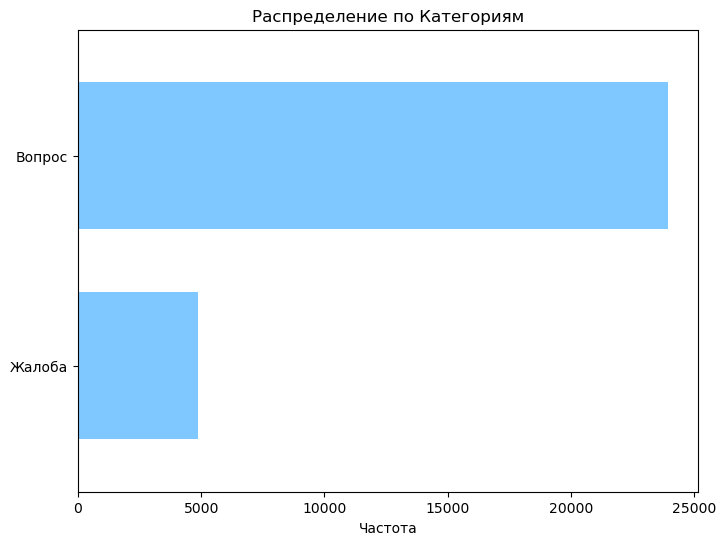

In [12]:
# 3.2 извлекаю частотную таблицу и строю график для категорий комментариев
freq_table = ns.frequencies()['Категория']
freq_sort= freq_table.sort_values('N') # Сортирую частоты по убыванию

plt.figure(figsize=(8,6))
freq_sort['N'].plot(kind="barh", color='#7fc7ff', width = 0.7)
plt.title(f'Распределение по Категориям')
plt.xlabel('Частота');

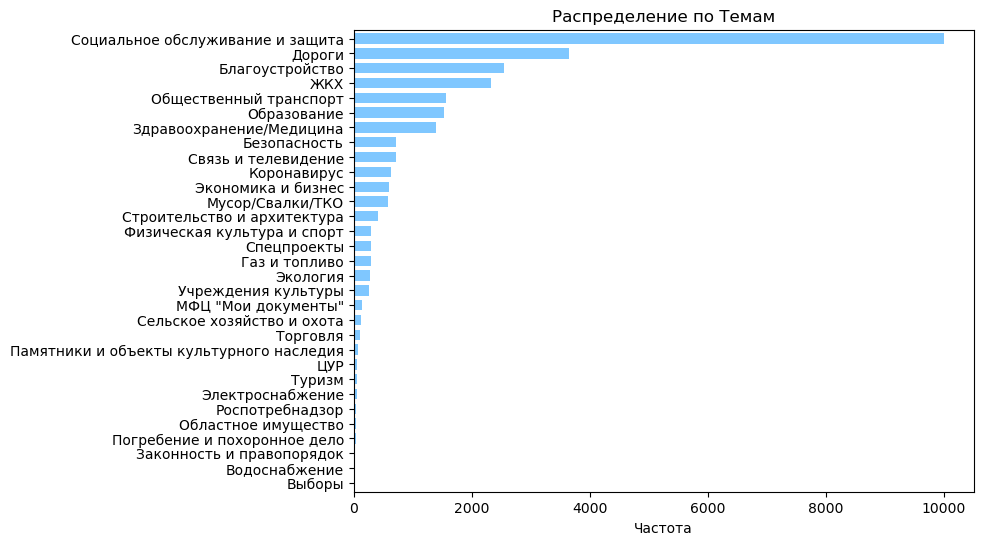

In [13]:
# 3.3 то же самое для тем сообшений
freq_table = ns.frequencies()['Тема']
freq_sort= freq_table.sort_values('N') # Сортирую частоты по убыванию

plt.figure(figsize=(8,6))
freq_sort['N'].plot(kind="barh", color='#7fc7ff', width = 0.7)
plt.title(f'Распределение по Темам')
plt.xlabel('Частота');

**Описательная статистика показывает, что:**
* чаще всего в датафрейме встречаются вопросы - 83% против 17% жалоб
* 3-мя самыми популярными темами сообщений являются: Социальное обслуживание и защита, Дороги и Благоустройство
* больше всего сообщений из Челябинска (18,1%), Белгорода (11,4%) и Уфы (10,8%)

Перевес в сторону вопросов способен повлиять на выполнение дальнейших задач классификации, так как модель может чаще классифицировать сообщение как вопрос из-за переобученности относительно данной категории.

In [14]:
# 3.4 ввожу класс методов для работы с таблицами сопряженности расчета критериев Хи-квадрат и его остатков
# для рассмотрения криволинейной связи между номинальными переменными 'Тема' и 'Категория'
ctab = Crosstab(df1, 'Тема', 'Категория')


CROSSTAB SUMMARY
------------------

Observed frequencies


Категория,Вопрос,Жалоба,Total
Тема,,,
Безопасность,521,192,713
Благоустройство,1748,802,2550
Водоснабжение,6,0,6
Выборы,2,0,2
Газ и топливо,253,40,293
Дороги,2455,1196,3651
ЖКХ,1590,729,2319
Законность и правопорядок,6,5,11
Здравоохранение/Медицина,1045,350,1395


------------------

Expected frequencies


Категория,Вопрос,Жалоба,Total
Тема,,,
Безопасность,592.349,120.651,713
Благоустройство,2118.501,431.499,2550
Водоснабжение,4.985,1.015,6
Выборы,1.662,0.338,2
Газ и топливо,243.420,49.580,293
Дороги,3033.195,617.805,3651
ЖКХ,1926.590,392.410,2319
Законность и правопорядок,9.139,1.861,11
Здравоохранение/Медицина,1158.945,236.055,1395


5 (8.065%) cells have expected frequency less than 5. The minimum expected frequency is 0.338.
------------------

Chi-square statistic is 3343.443 (p-value = 0.0).
------------------

Pearson's residuals


Категория,Вопрос,Жалоба
Тема,,
Безопасность,-2.932,6.496
Благоустройство,-8.050,17.836
Водоснабжение,0.455,-1.008
Выборы,0.263,-0.582
Газ и топливо,0.614,-1.361
Дороги,-10.498,23.262
ЖКХ,-7.668,16.991
Законность и правопорядок,-1.038,2.301
Здравоохранение/Медицина,-3.347,7.416


37 (59.677%) cells have Pearson's residual bigger than 1.96. 
The biggest residual is 23.262 (categories Дороги and Жалоба).
The smallest residual is -32.788 (categories Социальное обслуживание и защита and Жалоба).


In [15]:
# 3.5 отдельно положительные значимые остатки критерия Хи-квадрат
ctab.residuals_pearson > 1.96

Категория,Вопрос,Жалоба
Тема,,
Безопасность,False,True
Благоустройство,False,True
Водоснабжение,False,False
Выборы,False,False
Газ и топливо,False,False
Дороги,False,True
ЖКХ,False,True
Законность и правопорядок,False,True
Здравоохранение/Медицина,False,True


**Остатки выше 1.96 говорят о том, что:**
* категория "Вопрос" связана с темами: Коронавирус, Образование, Связь и телевидение, Социальное обслуживание и защита, Учреждения культуры
* категория "Жалоба" связана с темами: Безопасность, Благоустройство, Дороги, ЖКХ, Законность и правопорядок, Здравоохранение/Медицина, Мусор/Свалки/ТКО, Общественный транспорт, Погребение и похоронное дело, Торговля, Экология, Экономика и бизнес, Электроснабжение	
* без категорий (в условиях криволинейной связи) остались: 

### Рассмотрим комментарии пользователей

In [16]:
# 4 посчитаем максимальную длину сообщения
max_sequence_length = max(df1['text_token'].apply(len))

# посмотрим, сколько уникальных слов в датафрейме
all_words = [word for tokens in df1['text_token'] for word in tokens]
unique_words = set(all_words)
vocab_size = len(unique_words)


# Print the calculated values
print('Размер словаря:', vocab_size)
print('Максимальная длина сообщения:', max_sequence_length)

Размер словаря: 146
Максимальная длина сообщения: 4449


In [17]:
# 4.2 узнаем частоту встречаемости слов для выявления наиболее часто используемых
dt= df1['text_lemmatized'].astype(str)
p = Counter(" ".join(dt).split()).most_common(25)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(rslt)

                Word  Frequency
0   ['здравствуйте',       6861
1      'пожалуйста',       6609
2             'год',       6069
3         'ребёнок',       5505
4      'подсказать',       4378
5         'пособие',       3866
6             'это',       3861
7            'день',       3856
8         ['добрый',       3755
9         'сказать',       3067
10          'какой',       2881
11         'почему',       2826
12            'дом',       2813
13         'дорога',       2683
14         'вопрос',       2596
15           'быть',       2486
16          'район',       2268
17           'мочь',       2143
18        'выплата',       2049
19        'который',       2030
20          'город',       1966
21          'улица',       1915
22            'наш',       1743
23        'человек',       1690
24          'месяц',       1679


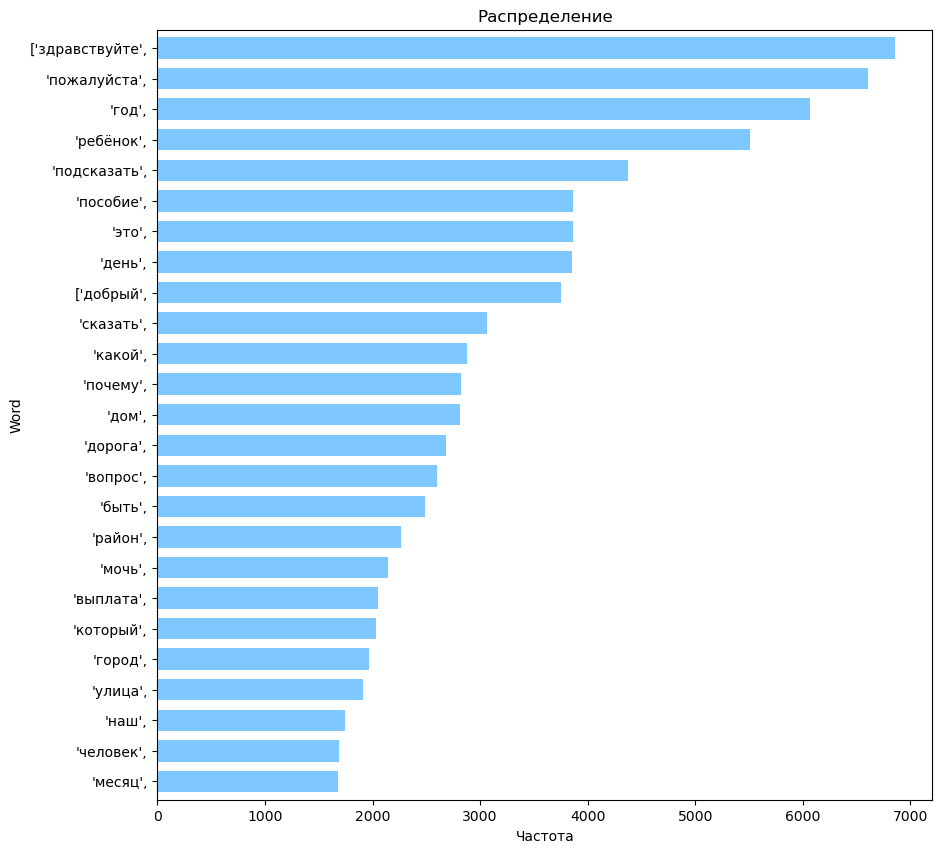

In [18]:
# 4.3 визуализируем
freq_sort= rslt.sort_values('Frequency')
freq_sort.set_index('Word', inplace=True)

plt.figure(figsize=(10,10))
freq_sort['Frequency'].plot(kind="barh", color='#7fc7ff', width = 0.7)
plt.title(f'Распределение')
plt.xlabel('Частота');

In [19]:
# 5.1 сделаем облако слов для наглядности
text = ' '.join([word for word in df1['text_lemmatized'].astype(str)])

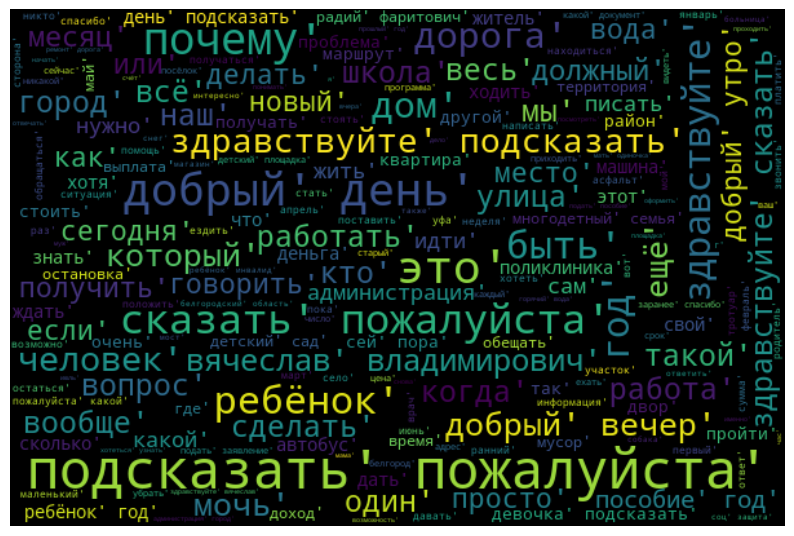

In [20]:
%matplotlib inline
# 5.2
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100,
                     background_color="black").generate(text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

* Размер словаря: 146
* Максимальная длина сообщения: 4449
* Самые частые слова - слова-обращения или просьбы. Для улучшения анализа следует расширить словарь стоп-слов (к примеру, избавиться от имен и отчеств или от слов приветствия)

## Обучение классификаторов <a id='section_id_2'></a>

__Выбор и обоснование:__

1. Random Forest:
   - Random Forest - это метод коллективного обучения, который объединяет несколько деревьев решений для повышения производительности и уменьшения переобучения.
   - Он хорошо работает как с числовыми, так и с категориальными функциями, что делает его подходящим для нашего смешанного типа данных (TF-IDF) после предварительной обработки.
   - Random Forest может обрабатывать большое количество объектов и фиксировать сложные взаимосвязи в данных.
   - Он, как правило, устойчив к выбросам и шуму, что полезно при работе с реальными данными.

2. BERT
   - BERT - это модель, которая может улавливать двунаправленный контекст и понимать значение слов на основе контекста.
   - Контекстуальное понимание: BERT может улавливать контекст и значение слов в предложении, что позволяет ему понимать нюансы различий между жалобами и вопросами в комментариях на русском языке.
   - BERT предварительно обучен на большом объеме текста, что дает прочную основу для решения различных задач NLP.
   - Для точной настройки его под конкретную задачу классификации требуется меньше данных по сравнению с обучением модели с нуля.

### Random Forest

In [21]:
# 6 посчитаем частоту для токенов
df1['tokens'] = df1['text_lemmatized']

token_counts = Counter(token for tokens in df1['tokens'] for token in tokens)
df1['token_frequency'] = df1['tokens'].apply(lambda tokens: sum(token_counts[token] for token in tokens))

# сделаем частоту 0 и 1
df1['token_frequency'] = df1['token_frequency'].apply(lambda x: 1 if x > 0 else x)
df1.head(10)

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized,tokens,token_frequency
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,'Вид из окна потрясающий (пр. С. Юлаева напрот...,Вид окна потрясающий Юлаева напротив Юбилейной...,"[вид, окно, потрясать, юлаева, напротив, юбиле...","[вид, окно, потрясать, юлаева, напротив, юбиле...",1
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...","'[id294938415:bp-88767010_4|Αнастасия], Здравс...",id294938415 88767010_4 Αнастасия Здравствуйте ...,"[αнастасия, здравствуйте, подсказать, оспорить...","[αнастасия, здравствуйте, подсказать, оспорить...",1
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,'[club53367440:bp-53367440_121743|Министерство...,club53367440 53367440_121743 Министерство здра...,"[министерство, здравствуйте, направить, сегодня]","[министерство, здравствуйте, направить, сегодня]",1
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...","'Девочки всем привет,у меня такой вопрос получ...",Девочки всем привет меня такой вопрос получила...,"[девочка, весь, привет, вопрос, получить, посо...","[девочка, весь, привет, вопрос, получить, посо...",1
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,'Когда будет приведён в порядок пруд в центре ...,Когда будет приведён порядок пруд центре Ивни ...,"[когда, привести, порядок, пруд, центр, ивень,...","[когда, привести, порядок, пруд, центр, ивень,...",1
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,'Обращаюсь от имени одиноких престарелых людей...,Обращаюсь имени одиноких престарелых людей жит...,"[обращаться, имя, одинокий, престарелый, челов...","[обращаться, имя, одинокий, престарелый, челов...",1
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...","'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",Добрый день Игорь Юрьевич марта 2022 года пере...,"[добрый, день, игорь, юриевич, март, год, пере...","[добрый, день, игорь, юриевич, март, год, пере...",1
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,'А про Камызякский район забыли?,про Камызякский район забыли,"[камызякский, район, забыть]","[камызякский, район, забыть]",1
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...","'Здравствуйте!Скажите пожалуйста,правда ли,что...",Здравствуйте Скажите пожалуйста правда что теп...,"[здравствуйте, сказать, пожалуйста, правда, со...","[здравствуйте, сказать, пожалуйста, правда, со...",1
10,2022-04-15 11:53:52.238,Вопрос,Социальное обслуживание и защита,Буздякский р-н,'Здравствуйте. Может мне кто то объяснит почем...,'Здравствуйте. Может мне кто то объяснит почем...,Здравствуйте Может мне кто объяснит почему мно...,"[здравствуйте, мочь, объяснить, почему, многие...","[здравствуйте, мочь, объяснить, почему, многие...",1


In [22]:
# 7 добавим id к документу, согласно дате публикации
df1['Дата'] = pd.to_datetime(df1['Дата'])
df1.sort_values('Дата', inplace=True)
df1.reset_index(drop=True, inplace=True)
df1['document_id'] = df1.index
df1

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized,tokens,token_frequency,document_id
0,2022-01-01 03:46:08.515,Жалоба,Здравоохранение/Медицина,Стерлитамак г,'Зато нет лекарств для диабетиков...Зачем выпи...,'Зато нет лекарств для диабетиков...Зачем выпи...,Зато нет лекарств для диабетиков Зачем выписыв...,"[зато, лекарство, диабетик, зачем, выписывать,...","[зато, лекарство, диабетик, зачем, выписывать,...",1,0
1,2022-01-01 04:57:36.523,Вопрос,Общественный транспорт,Челябинск г,'до пос.Каштак как обычно ничего нового пускат...,'до пос.Каштак как обычно ничего нового пускат...,пос Каштак как обычно ничего нового пускать будут,"[пос, каштак, обычно, новый, пускать, быть]","[пос, каштак, обычно, новый, пускать, быть]",1,1
2,2022-01-01 06:43:59.994,Жалоба,Общественный транспорт,Уфа г,'Спасибо за поздравления. Вы про транспорт люд...,'Спасибо за поздравления. Вы про транспорт люд...,Спасибо поздравления про транспорт людей услыш...,"[спасибо, поздравление, транспорт, человек, ус...","[спасибо, поздравление, транспорт, человек, ус...",1,2
3,2022-01-01 06:46:23.132,Вопрос,Связь и телевидение,Иглинский р-н,'Добрый день! С Новым годом! Подскажите график...,'Добрый день! С Новым годом! Подскажите график...,Добрый день Новым годом Подскажите график рабо...,"[добрый, день, новый, год, подсказать, график,...","[добрый, день, новый, год, подсказать, график,...",1,3
4,2022-01-01 07:57:56.929,Вопрос,Газ и топливо,Виноградовский р-н,'[club186437597|Министерство ТЭК и ЖКХ Арханге...,'[club186437597|Министерство ТЭК и ЖКХ Арханге...,club186437597 Министерство ТЭК ЖКХ Архангельск...,"[министерство, тэк, жкх, архангельский, област...","[министерство, тэк, жкх, архангельский, област...",1,4
...,...,...,...,...,...,...,...,...,...,...,...
28834,2022-07-19 22:47:25.345,Вопрос,Дороги,Белгородский р-н,"'Добрый вечер, а п. Дубовое, мкр. ""Тополек' по...","'Добрый вечер, а п. Дубовое, мкр. ""Тополек' по...",Добрый вечер Дубовое мкр Тополек попадёт эти,"[добрый, вечер, дубовый, мкр, тополёк, попасть]","[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,28834
28835,2022-07-19 22:50:05.129,Вопрос,Газ и топливо,Старооскольский ГО,"'Уважаемый Губернатора, когда же дойдёт время ...","'Уважаемый Губернатора, когда же дойдёт время ...",Уважаемый Губернатора когда дойдёт время подкл...,"[уважаемый, губернатор, дойти, время, подключе...","[уважаемый, губернатор, дойти, время, подключе...",1,28835
28836,2022-07-19 22:52:17.033,Вопрос,Благоустройство,Старооскольский ГО,'А когда же будут запланированы работы по очис...,'А когда же будут запланированы работы по очис...,когда будут запланированы работы очистке благо...,"[быть, запланировать, работа, очистка, благоус...","[быть, запланировать, работа, очистка, благоус...",1,28836
28837,2022-07-19 22:58:18.815,Вопрос,Торговля,Новооскольский ГО,"'Добрый вечер,Вячеслав Владимирович,живу в дер...","'Добрый вечер,Вячеслав Владимирович,живу в дер...",Добрый вечер Вячеслав Владимирович живу деревн...,"[добрый, вечер, вячеслав, владимирович, жить, ...","[добрый, вечер, вячеслав, владимирович, жить, ...",1,28837


In [23]:
# 8 отберем необходимые столбцы
documents_tokens = df1[['document_id', 'tokens', 'token_frequency', 'Дата']]
markup = df1[['document_id', 'Категория', 'token_frequency', 'Дата']]

# проверим несовпадения
contradictions = markup.groupby('document_id')['Категория'].nunique().gt(1)
contradictions = contradictions[contradictions].index.tolist()
contradictions

[]

In [24]:
# 9 избавимся от части классифицированных тем, чтобы было на чем учить, а после и применять модель классификатора
combined_df = pd.merge(documents_tokens, markup, on='document_id', how='inner')
combined_df1 = combined_df # для проверки совпадений после классификации

column_name = 'Категория'
null_fraction = 0.6
null_indices = random.sample(range(len(combined_df)), int(null_fraction * len(combined_df)))

# делаем NaN
combined_df.loc[null_indices, column_name] = None
combined_df

,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515
1,1,"[пос, каштак, обычно, новый, пускать, быть]",1,2022-01-01 04:57:36.523,None,1,2022-01-01 04:57:36.523
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929
...,...,...,...,...,...,...,...
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,None,1,2022-07-19 22:47:25.345
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,None,1,2022-07-19 22:50:05.129
28836,28836,"[быть, запланировать, работа, очистка, благоус...",1,2022-07-19 22:52:17.033,Вопрос,1,2022-07-19 22:52:17.033
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,None,1,2022-07-19 22:58:18.815


In [25]:
# 10 разделим датафрейм на учительский и неклассифицированный
unmarked_df = combined_df[combined_df['Категория'].isnull()]
teacher_df = combined_df[combined_df['Категория'].notnull()]
unmarked_df_copy = unmarked_df.copy()
# разделим учительский датафрейм
X = teacher_df.drop(['Категория'], axis=1)
y = teacher_df['Категория']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# переделаем колонку в строчный формат
X_train['tokens_str'] = X_train['tokens'].apply(lambda tokens: ' '.join(tokens))
X_test['tokens_str'] = X_test['tokens'].apply(lambda tokens: ' '.join(tokens))

# найдем константы
constant_tokens = X_train.drop(['tokens', 'tokens_str'], axis=1).columns[X_train.drop(['tokens', 'tokens_str'], axis=1).nunique() == 1].tolist()

# исключим константу из предикторов
X_train = X_train.drop(constant_tokens, axis=1)
X_test = X_test.drop(constant_tokens, axis=1)

# избавляемся от ненужной колонки
X_train = X_train.drop('tokens_str', axis=1)
X_test = X_test.drop('tokens_str', axis=1)

In [26]:
# 11.1 создадим строковые данные
X_train['tokens_str'] = X_train['tokens'].apply(lambda tokens: ' '.join(tokens))
# сделаем копии датафреймов
X_train_copy = X_train.copy()
unmarked_df_copy = unmarked_df_copy

# вновь создаем строковые данные
X_train_copy['tokens_str'] = X_train_copy['tokens'].apply(lambda tokens: ' '.join(tokens))
unmarked_df_copy['tokens_str'] = unmarked_df_copy['tokens'].apply(lambda tokens: ' '.join(tokens))

# делаем векторизатор
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_copy['tokens_str'])

# фиттим данные
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_vectorized, y_train)

# векторизуем непромаркированные данные
unmarked_df_vectorized = vectorizer.transform(unmarked_df_copy['tokens_str'])

# предсказываем тематики
unmarked_df_copy['Категория'] = rf_classifier.predict(unmarked_df_vectorized)

# удаляем ненужные колонки
X_train_copy.drop('tokens_str', axis=1, inplace=True)
unmarked_df_copy.drop('tokens_str', axis=1, inplace=True)

# конкатенируем в финальный датафрейм
final_df1 = pd.concat([teacher_df, unmarked_df_copy])
final_df1

,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929
6,6,"[новый, год, когда, откытие, матема, лицей, ра...",1,2022-01-01 08:20:47.274,Вопрос,1,2022-01-01 08:20:47.274
...,...,...,...,...,...,...,...
28833,28833,"[здравствуйте, сказать, пожалуйста, сделать, р...",1,2022-07-19 22:46:31.916,Вопрос,1,2022-07-19 22:46:31.916
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,Вопрос,1,2022-07-19 22:47:25.345
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,Вопрос,1,2022-07-19 22:50:05.129
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,Вопрос,1,2022-07-19 22:58:18.815


Так, был получен датафрейм, часть котрого была классифицирована алгоритмом Random Forest. В дальнейшем можно будет сравнить его по точности со следующей моделью для принятия оптимального решения.

In [27]:
# 11.2 оценим качество модели
# получим истинные значения и предсказанные
y_true = final_df1['Категория'].dropna()  # True labels for labeled data
y_pred = final_df1['Категория'].fillna('unclassified')  # Predicted labels for both labeled and unlabeled data

# посчитаем показатели классификатора
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


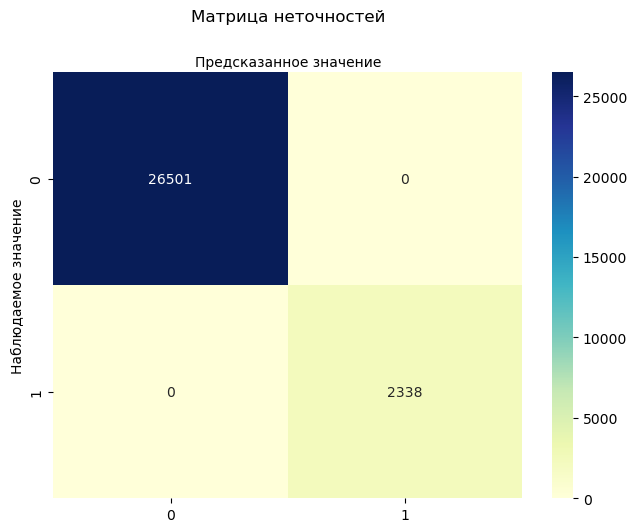

In [28]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Матрица неточностей', y=1.1)
plt.ylabel('Наблюдаемое значение')
plt.xlabel('Предсказанное значение');

Большая часть наблюдений относится к вопросам, из-за чего может возникать искажение в оценке эффективности модели. То есть, высокий параметр точности не будет на 100% свидетельствовать о том, что жалобы не были ложно причислены к вопросам. Но при этом, согласно матрице, ложных присвоений категорий нет.

### Модель BERT

In [29]:
# 12
# загрузим предобученную модель для работы с русскоязычными последовательностями 
model_name = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [30]:
# 13.1
combined_df_copy = combined_df.copy()

# преобразуем списки токенов для teacher_df и unmarked_df_copy
X_train['tokens_str'] = X_train['tokens'].apply(lambda tokens: ' '.join(tokens))
unmarked_df_copy['tokens_str'] = unmarked_df_copy['tokens'].apply(lambda tokens: ' '.join(tokens))

# создадим объекты подгрузки данных для обучения и тестирования
train_encodings = tokenizer(X_train['tokens_str'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True)
test_encodings = tokenizer(unmarked_df_copy['tokens_str'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True)

# переведем метки в числовой формат
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# конвертируем метки в PyTorch тензоры
y_train_torch = torch.tensor(y_train_encoded, dtype=torch.long)

# зададим DataLoader для обучения и тестирования
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Epoch 1, Train Loss: 0.7283
Epoch 2, Train Loss: 0.7320
Epoch 3, Train Loss: 0.7340
Epoch 4, Train Loss: 0.7144
Epoch 5, Train Loss: 0.7383
Epoch 6, Train Loss: 0.7159
Epoch 7, Train Loss: 0.7404
Epoch 8, Train Loss: 0.7138
Epoch 9, Train Loss: 0.7157
Epoch 10, Train Loss: 0.7199
Epoch 11, Train Loss: 0.7329
Epoch 12, Train Loss: 0.7201
Epoch 13, Train Loss: 0.7243
Epoch 14, Train Loss: 0.7409
Epoch 15, Train Loss: 0.7474
Epoch 16, Train Loss: 0.7340
Epoch 17, Train Loss: 0.7330
Epoch 18, Train Loss: 0.7286
Epoch 19, Train Loss: 0.7171
Epoch 20, Train Loss: 0.7065
Epoch 21, Train Loss: 0.7334
Epoch 22, Train Loss: 0.7378
Epoch 23, Train Loss: 0.7135
Epoch 24, Train Loss: 0.7092
Epoch 25, Train Loss: 0.7093
Epoch 26, Train Loss: 0.7176
Epoch 27, Train Loss: 0.6915
Epoch 28, Train Loss: 0.7032
Epoch 29, Train Loss: 0.6677
Epoch 30, Train Loss: 0.6582
Epoch 31, Train Loss: 0.6460
Epoch 32, Train Loss: 0.6630
Epoch 33, Train Loss: 0.6432
Epoch 34, Train Loss: 0.6211
Epoch 35, Train Loss: 0

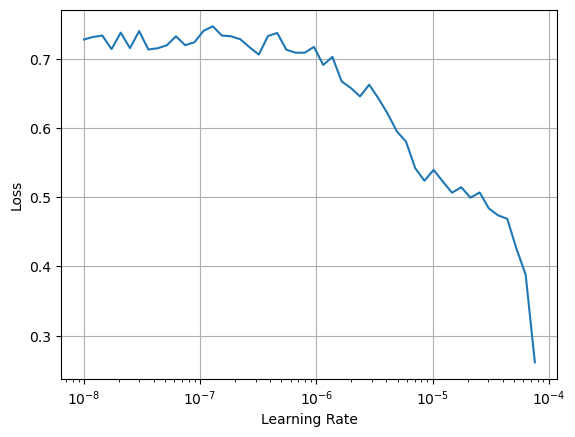

In [31]:
# 13.2 выявим оптимальное значение параметра обучения модели learning rate
# проводилась на малом числе наблюдений (100) !!!!! (чтобы не грузилось 6+ часов, лучше не запускать :) )

train_dataset_part = train_dataset

train_loader1 = DataLoader(train_dataset_part, batch_size=32, shuffle=True)

# задаем функцию MAE (Mean Absolute Error)
loss_fn = torch.nn.L1Loss()

# настроим оптимизатор
learning_rate = 1e-8
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# задаем пустые списки для хранения значений
learning_rates = []
losses = []

# тестируем параметр
for epoch in range(50):
    model.train()
    total_loss = 0

    for batch_idx, (input_ids_batch, attention_mask_batch, labels_batch) in enumerate(train_loader1, 1):
        input_ids_batch, attention_mask_batch, labels_batch = input_ids_batch.to(device), attention_mask_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader1)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

    # сохраняем показатель для каждого этапа
    learning_rates.append(learning_rate)
    losses.append(avg_train_loss)

    # постепенно повышаем показатель с каждым новым этапом
    learning_rate *= 1.2
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

# выведем график
plt.semilogx(learning_rates, losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Оптимальным значением параметра learning rate будет 1e-5

In [31]:
# 14.1 настройки модели
num_epochs = 2
learning_rate = 1e-5

# зададим функцию подсчета потерь модели и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    total_loss = 0

    for batch_idx, (input_ids_batch, attention_mask_batch, labels_batch) in enumerate(train_loader, 1):
        input_ids_batch, attention_mask_batch, labels_batch = input_ids_batch.to(device), attention_mask_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}')

Epochs:   0%|          | 0/2 [00:00<?, ?epoch/s]

Epoch 1/2, Batch 1/271, Loss: 0.6670
Epoch 1/2, Batch 2/271, Loss: 0.6505
Epoch 1/2, Batch 3/271, Loss: 0.6059
Epoch 1/2, Batch 4/271, Loss: 0.5913
Epoch 1/2, Batch 5/271, Loss: 0.5414
Epoch 1/2, Batch 6/271, Loss: 0.5795
Epoch 1/2, Batch 7/271, Loss: 0.4942
Epoch 1/2, Batch 8/271, Loss: 0.5109
Epoch 1/2, Batch 9/271, Loss: 0.5244
Epoch 1/2, Batch 10/271, Loss: 0.5080
Epoch 1/2, Batch 11/271, Loss: 0.5217
Epoch 1/2, Batch 12/271, Loss: 0.4278
Epoch 1/2, Batch 13/271, Loss: 0.6119
Epoch 1/2, Batch 14/271, Loss: 0.5260
Epoch 1/2, Batch 15/271, Loss: 0.4768
Epoch 1/2, Batch 16/271, Loss: 0.5890
Epoch 1/2, Batch 17/271, Loss: 0.5010
Epoch 1/2, Batch 18/271, Loss: 0.3907
Epoch 1/2, Batch 19/271, Loss: 0.4461
Epoch 1/2, Batch 20/271, Loss: 0.3147
Epoch 1/2, Batch 21/271, Loss: 0.3483
Epoch 1/2, Batch 22/271, Loss: 0.2312
Epoch 1/2, Batch 23/271, Loss: 0.3991
Epoch 1/2, Batch 24/271, Loss: 0.7192
Epoch 1/2, Batch 25/271, Loss: 0.2448
Epoch 1/2, Batch 26/271, Loss: 0.5766
Epoch 1/2, Batch 27/2

Epoch 1/2, Batch 214/271, Loss: 0.3705
Epoch 1/2, Batch 215/271, Loss: 0.4856
Epoch 1/2, Batch 216/271, Loss: 0.5006
Epoch 1/2, Batch 217/271, Loss: 0.2950
Epoch 1/2, Batch 218/271, Loss: 0.1947
Epoch 1/2, Batch 219/271, Loss: 0.2076
Epoch 1/2, Batch 220/271, Loss: 0.4727
Epoch 1/2, Batch 221/271, Loss: 0.3112
Epoch 1/2, Batch 222/271, Loss: 0.2540
Epoch 1/2, Batch 223/271, Loss: 0.1842
Epoch 1/2, Batch 224/271, Loss: 0.3138
Epoch 1/2, Batch 225/271, Loss: 0.5053
Epoch 1/2, Batch 226/271, Loss: 0.5349
Epoch 1/2, Batch 227/271, Loss: 0.1899
Epoch 1/2, Batch 228/271, Loss: 0.3846
Epoch 1/2, Batch 229/271, Loss: 0.1890
Epoch 1/2, Batch 230/271, Loss: 0.2347
Epoch 1/2, Batch 231/271, Loss: 0.3424
Epoch 1/2, Batch 232/271, Loss: 0.3315
Epoch 1/2, Batch 233/271, Loss: 0.2432
Epoch 1/2, Batch 234/271, Loss: 0.2568
Epoch 1/2, Batch 235/271, Loss: 0.3751
Epoch 1/2, Batch 236/271, Loss: 0.5365
Epoch 1/2, Batch 237/271, Loss: 0.3919
Epoch 1/2, Batch 238/271, Loss: 0.1858
Epoch 1/2, Batch 239/271,

Epochs:  50%|█████     | 1/2 [1:11:40<1:11:40, 4300.51s/epoch]

Epoch 1/2, Batch 271/271, Loss: 0.5247
Epoch 1/2, Train Loss: 0.3887
Epoch 2/2, Batch 1/271, Loss: 0.3105
Epoch 2/2, Batch 2/271, Loss: 0.2259
Epoch 2/2, Batch 3/271, Loss: 0.4628
Epoch 2/2, Batch 4/271, Loss: 0.2689
Epoch 2/2, Batch 5/271, Loss: 0.2852
Epoch 2/2, Batch 6/271, Loss: 0.1631
Epoch 2/2, Batch 7/271, Loss: 0.2849
Epoch 2/2, Batch 8/271, Loss: 0.2690
Epoch 2/2, Batch 9/271, Loss: 0.4226
Epoch 2/2, Batch 10/271, Loss: 0.3795
Epoch 2/2, Batch 11/271, Loss: 0.2196
Epoch 2/2, Batch 12/271, Loss: 0.4639
Epoch 2/2, Batch 13/271, Loss: 0.4126
Epoch 2/2, Batch 14/271, Loss: 0.3624
Epoch 2/2, Batch 15/271, Loss: 0.2254
Epoch 2/2, Batch 16/271, Loss: 0.5447
Epoch 2/2, Batch 17/271, Loss: 0.2996
Epoch 2/2, Batch 18/271, Loss: 0.1795
Epoch 2/2, Batch 19/271, Loss: 0.1395
Epoch 2/2, Batch 20/271, Loss: 0.2292
Epoch 2/2, Batch 21/271, Loss: 0.3160
Epoch 2/2, Batch 22/271, Loss: 0.1974
Epoch 2/2, Batch 23/271, Loss: 0.2534
Epoch 2/2, Batch 24/271, Loss: 0.2304
Epoch 2/2, Batch 25/271, Los

Epoch 2/2, Batch 213/271, Loss: 0.3568
Epoch 2/2, Batch 214/271, Loss: 0.2906
Epoch 2/2, Batch 215/271, Loss: 0.2439
Epoch 2/2, Batch 216/271, Loss: 0.3867
Epoch 2/2, Batch 217/271, Loss: 0.2308
Epoch 2/2, Batch 218/271, Loss: 0.2527
Epoch 2/2, Batch 219/271, Loss: 0.3332
Epoch 2/2, Batch 220/271, Loss: 0.3253
Epoch 2/2, Batch 221/271, Loss: 0.3221
Epoch 2/2, Batch 222/271, Loss: 0.3259
Epoch 2/2, Batch 223/271, Loss: 0.3142
Epoch 2/2, Batch 224/271, Loss: 0.4601
Epoch 2/2, Batch 225/271, Loss: 0.3315
Epoch 2/2, Batch 226/271, Loss: 0.3041
Epoch 2/2, Batch 227/271, Loss: 0.4563
Epoch 2/2, Batch 228/271, Loss: 0.2953
Epoch 2/2, Batch 229/271, Loss: 0.3655
Epoch 2/2, Batch 230/271, Loss: 0.2295
Epoch 2/2, Batch 231/271, Loss: 0.1748
Epoch 2/2, Batch 232/271, Loss: 0.3869
Epoch 2/2, Batch 233/271, Loss: 0.4559
Epoch 2/2, Batch 234/271, Loss: 0.3725
Epoch 2/2, Batch 235/271, Loss: 0.3449
Epoch 2/2, Batch 236/271, Loss: 0.1805
Epoch 2/2, Batch 237/271, Loss: 0.3198
Epoch 2/2, Batch 238/271,

Epochs: 100%|██████████| 2/2 [5:56:10<00:00, 10685.37s/epoch] 

Epoch 2/2, Batch 271/271, Loss: 0.1590
Epoch 2/2, Train Loss: 0.3116


In [37]:
# 14.2 рассмотрим модель подробнее
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [38]:
# 15 повторно приведем данные для модели BERT
unmarked_df = combined_df[combined_df['Категория'].isnull()]
teacher_df = combined_df[combined_df['Категория'].notnull()]
unmarked_df_copy = unmarked_df.copy()
unmarked_df_copy['tokens_str'] = unmarked_df_copy['tokens'].apply(lambda tokens: ' '.join(tokens))

# разделим учительский датафрейм
X = teacher_df.drop(['Категория'], axis=1)
y = teacher_df['Категория']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# переделаем колонку в строчный формат
X_train['tokens_str'] = X_train['tokens'].apply(lambda tokens: ' '.join(tokens))
X_test['tokens_str'] = X_test['tokens'].apply(lambda tokens: ' '.join(tokens))

In [39]:
# 16 токенизируем текстовые данные
X_train_encoded = tokenizer(X_train['tokens_str'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
X_test_encoded = tokenizer(unmarked_df_copy['tokens_str'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# конвертируем метки
y_train[y_train == 'Вопрос'] = 1
y_train[y_train == 'Жалоба'] = 0
y_train = y_train.astype(int).values
y_train_torch = torch.tensor(y_train, dtype=torch.long)

# создадим объекты для тестирования и обучения
train_dataset = TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# задаем предсказанные значения
y_pred = np.zeros(len(unmarked_df_copy), dtype=int)

with torch.no_grad():
    for i, (input_ids_batch, attention_mask_batch, _) in enumerate(train_loader):
        input_ids_batch, attention_mask_batch = input_ids_batch.to(device), attention_mask_batch.to(device)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, axis=1).cpu().numpy()
        start_idx = i * train_loader.batch_size
        end_idx = min(start_idx + len(input_ids_batch), len(unmarked_df_copy))
        y_pred[start_idx:end_idx] = batch_predictions[:end_idx - start_idx]

# обновляем темы в unmarked_df_copy предсказанными значениями меток
unmarked_df_copy['Категория'] = y_pred

# конкатенируем датафрейм
final_df2 = pd.concat([teacher_df, unmarked_df_copy])
final_df2

,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y,tokens_str
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515,NaN
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994,NaN
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132,NaN
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929,NaN
6,6,"[новый, год, когда, откытие, матема, лицей, ра...",1,2022-01-01 08:20:47.274,Вопрос,1,2022-01-01 08:20:47.274,NaN
...,...,...,...,...,...,...,...,...
28833,28833,"[здравствуйте, сказать, пожалуйста, сделать, р...",1,2022-07-19 22:46:31.916,0,1,2022-07-19 22:46:31.916,здравствуйте сказать пожалуйста сделать ремонт...
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,0,1,2022-07-19 22:47:25.345,добрый вечер дубовый мкр тополёк попасть
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,0,1,2022-07-19 22:50:05.129,уважаемый губернатор дойти время подключение г...
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,0,1,2022-07-19 22:58:18.815,добрый вечер вячеслав владимирович жить деревн...


In [40]:
# 17 перекодируем категорию обратно в номинальный тип переменной вместо дихотомической интервальной
# Create a mapping dictionary to convert numerical labels back to categories
label_mapping = {0: 'Жалоба', 1: 'Вопрос'}

# Convert numerical labels in 'Категория' column back to original categories
final_df2['Категория'] = final_df2['Категория'].apply(lambda x: label_mapping.get(x) if isinstance(x, int) else x)
final_df2

,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y,tokens_str
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515,NaN
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994,NaN
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132,NaN
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929,NaN
6,6,"[новый, год, когда, откытие, матема, лицей, ра...",1,2022-01-01 08:20:47.274,Вопрос,1,2022-01-01 08:20:47.274,NaN
...,...,...,...,...,...,...,...,...
28833,28833,"[здравствуйте, сказать, пожалуйста, сделать, р...",1,2022-07-19 22:46:31.916,Жалоба,1,2022-07-19 22:46:31.916,здравствуйте сказать пожалуйста сделать ремонт...
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,Жалоба,1,2022-07-19 22:47:25.345,добрый вечер дубовый мкр тополёк попасть
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,Жалоба,1,2022-07-19 22:50:05.129,уважаемый губернатор дойти время подключение г...
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,Жалоба,1,2022-07-19 22:58:18.815,добрый вечер вячеслав владимирович жить деревн...


Получили 2-й датафрейм, часть которого класифицирована BERT. Теперь можно сравнить эффективность классификации за счет изначальной разметки датафрейма.

## Оценка качества полученных моделей <a id='section_id_3'></a>

In [51]:
# 18.1 отсортируем все датафреймы по дате, чтобы строки совпадали
final_df1['Дата_y'] = pd.to_datetime(final_df1['Дата_y'])
final_df1.sort_values('Дата_y', inplace=True)

final_df2['Дата_y'] = pd.to_datetime(final_df2['Дата_y'])
final_df2.sort_values('Дата_y', inplace=True)

df1['Дата'] = pd.to_datetime(df1['Дата'])
df1.sort_values('Дата', inplace=True)
display(final_df1,final_df2,df1)

,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515
1,1,"[пос, каштак, обычно, новый, пускать, быть]",1,2022-01-01 04:57:36.523,Вопрос,1,2022-01-01 04:57:36.523
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929
...,...,...,...,...,...,...,...
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,Вопрос,1,2022-07-19 22:47:25.345
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,Вопрос,1,2022-07-19 22:50:05.129
28836,28836,"[быть, запланировать, работа, очистка, благоус...",1,2022-07-19 22:52:17.033,Вопрос,1,2022-07-19 22:52:17.033
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,Вопрос,1,2022-07-19 22:58:18.815


,document_id,tokens,token_frequency_x,Дата_x,Категория,token_frequency_y,Дата_y,tokens_str
0,0,"[зато, лекарство, диабетик, зачем, выписывать,...",1,2022-01-01 03:46:08.515,Жалоба,1,2022-01-01 03:46:08.515,NaN
1,1,"[пос, каштак, обычно, новый, пускать, быть]",1,2022-01-01 04:57:36.523,Жалоба,1,2022-01-01 04:57:36.523,пос каштак обычно новый пускать быть
2,2,"[спасибо, поздравление, транспорт, человек, ус...",1,2022-01-01 06:43:59.994,Жалоба,1,2022-01-01 06:43:59.994,NaN
3,3,"[добрый, день, новый, год, подсказать, график,...",1,2022-01-01 06:46:23.132,Вопрос,1,2022-01-01 06:46:23.132,NaN
4,4,"[министерство, тэк, жкх, архангельский, област...",1,2022-01-01 07:57:56.929,Вопрос,1,2022-01-01 07:57:56.929,NaN
...,...,...,...,...,...,...,...,...
28834,28834,"[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,2022-07-19 22:47:25.345,Жалоба,1,2022-07-19 22:47:25.345,добрый вечер дубовый мкр тополёк попасть
28835,28835,"[уважаемый, губернатор, дойти, время, подключе...",1,2022-07-19 22:50:05.129,Жалоба,1,2022-07-19 22:50:05.129,уважаемый губернатор дойти время подключение г...
28836,28836,"[быть, запланировать, работа, очистка, благоус...",1,2022-07-19 22:52:17.033,Вопрос,1,2022-07-19 22:52:17.033,NaN
28837,28837,"[добрый, вечер, вячеслав, владимирович, жить, ...",1,2022-07-19 22:58:18.815,Жалоба,1,2022-07-19 22:58:18.815,добрый вечер вячеслав владимирович жить деревн...


,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized,tokens,token_frequency,document_id
0,2022-01-01 03:46:08.515,Жалоба,Здравоохранение/Медицина,Стерлитамак г,'Зато нет лекарств для диабетиков...Зачем выпи...,'Зато нет лекарств для диабетиков...Зачем выпи...,Зато нет лекарств для диабетиков Зачем выписыв...,"['зато', 'лекарство', 'диабетик', 'зачем', 'вы...","[зато, лекарство, диабетик, зачем, выписывать,...",1,0
1,2022-01-01 04:57:36.523,Вопрос,Общественный транспорт,Челябинск г,'до пос.Каштак как обычно ничего нового пускат...,'до пос.Каштак как обычно ничего нового пускат...,пос Каштак как обычно ничего нового пускать будут,"['пос', 'каштак', 'обычно', 'новый', 'пускать'...","[пос, каштак, обычно, новый, пускать, быть]",1,1
2,2022-01-01 06:43:59.994,Жалоба,Общественный транспорт,Уфа г,'Спасибо за поздравления. Вы про транспорт люд...,'Спасибо за поздравления. Вы про транспорт люд...,Спасибо поздравления про транспорт людей услыш...,"['спасибо', 'поздравление', 'транспорт', 'чело...","[спасибо, поздравление, транспорт, человек, ус...",1,2
3,2022-01-01 06:46:23.132,Вопрос,Связь и телевидение,Иглинский р-н,'Добрый день! С Новым годом! Подскажите график...,'Добрый день! С Новым годом! Подскажите график...,Добрый день Новым годом Подскажите график рабо...,"['добрый', 'день', 'новый', 'год', 'подсказать...","[добрый, день, новый, год, подсказать, график,...",1,3
4,2022-01-01 07:57:56.929,Вопрос,Газ и топливо,Виноградовский р-н,'[club186437597|Министерство ТЭК и ЖКХ Арханге...,'[club186437597|Министерство ТЭК и ЖКХ Арханге...,club186437597 Министерство ТЭК ЖКХ Архангельск...,"['министерство', 'тэк', 'жкх', 'архангельский'...","[министерство, тэк, жкх, архангельский, област...",1,4
...,...,...,...,...,...,...,...,...,...,...,...
28834,2022-07-19 22:47:25.345,Вопрос,Дороги,Белгородский р-н,"'Добрый вечер, а п. Дубовое, мкр. ""Тополек' по...","'Добрый вечер, а п. Дубовое, мкр. ""Тополек' по...",Добрый вечер Дубовое мкр Тополек попадёт эти,"['добрый', 'вечер', 'дубовый', 'мкр', 'тополёк...","[добрый, вечер, дубовый, мкр, тополёк, попасть]",1,28834
28835,2022-07-19 22:50:05.129,Вопрос,Газ и топливо,Старооскольский ГО,"'Уважаемый Губернатора, когда же дойдёт время ...","'Уважаемый Губернатора, когда же дойдёт время ...",Уважаемый Губернатора когда дойдёт время подкл...,"['уважаемый', 'губернатор', 'дойти', 'время', ...","[уважаемый, губернатор, дойти, время, подключе...",1,28835
28836,2022-07-19 22:52:17.033,Вопрос,Благоустройство,Старооскольский ГО,'А когда же будут запланированы работы по очис...,'А когда же будут запланированы работы по очис...,когда будут запланированы работы очистке благо...,"['быть', 'запланировать', 'работа', 'очистка',...","[быть, запланировать, работа, очистка, благоус...",1,28836
28837,2022-07-19 22:58:18.815,Вопрос,Торговля,Новооскольский ГО,"'Добрый вечер,Вячеслав Владимирович,живу в дер...","'Добрый вечер,Вячеслав Владимирович,живу в дер...",Добрый вечер Вячеслав Владимирович живу деревн...,"['добрый', 'вечер', 'вячеслав', 'владимирович'...","[добрый, вечер, вячеслав, владимирович, жить, ...",1,28837


In [52]:
# 18.2 проверим, какой алгоритм справился с задачей классификации лучше всего
def calculate_column_match_percentage(original_df, compared_df):
    column_name = 'Категория'
    
    if column_name not in original_df.columns or column_name not in compared_df.columns:
        print(f"Столбец '{column_name}' не найден в одном или обоих датафреймах.")
        return None
    
    original_column = original_df[column_name]
    compared_column = compared_df[column_name]
    
    # обновим индекс
    compared_column = compared_column.reset_index(drop=True)
    original_column = original_column.reset_index(drop=True)
    
    total_rows = len(original_column)
    matches = sum(original_column == compared_column)
    
    match_percentage = matches * 100 / total_rows
    
    return match_percentage

original_df = df1
compared_df1 = final_df1
compared_df2 = final_df2

match_percentage1 = calculate_column_match_percentage(original_df, compared_df1)
match_percentage2 = calculate_column_match_percentage(original_df, compared_df2)

if match_percentage1 is not None:
    print(f"Процент совпадений 'Категория' для Random Forest: {round(match_percentage1,2)}%")

if match_percentage2 is not None:
    print(f"Процент совпадений 'Категория' для BERT: {round(match_percentage2,2)}%")

Процент совпадений 'Категория' для Random Forest: 90.46%
Процент совпадений 'Категория' для BERT: 52.02%


## Выводы по классификаторам <a id='section_id_4'></a>

__Random Forest:__
- довольно доступная и менее ресурсозатратная модель классификации
- точность сильно зависит от входящих данных: в этом случае возможен "перекос" в сторону классификации сообщений как вопросов. Это происходит из-за того, что модель изначально обучается на данных, которые чаще всего имеют категорию "вопрос"
- процент совпадений с оригинальным датафреймом составил 90.46%, что является высоким показателем модели

__BERT:__
- ресурсозатратная, но более точная модель, которая позволяет опираться на контекст сообщений при определении класса
- как раз ресурсозатратность является основным минусом. Следует больше времени уделить оптимизации процесса обучения, что упростит обработку и классификацию данных
- процент совпадений составил 52.02%, что является средним показателем

__Вывод:__
Классификатор Random Forest является более эффективным решением относительно поставленной задачи. Следовательно, именно эту обученную модель следует применять для присвоения класса жалоба/вопрос.


## Описание возникших проблем и возможные пути дальнейшей работы с данными <a id='section_id_5'></a>

__Основные проблемы при работе с данными заключались в:__
* препроцессинге данных - избавление от никнеймов пользователей, необходимость в расширении словаря стоп-слов
* тип данных - приходилось адаптировать/менять типы данных в соответствии с моделями (особенно для BERT)
* сложность оптимизации модели BERT для более эффективной и быстрой работы с данными

__Относительно обогащения данных:__
* интересно было бы разделить пользователей относительно соц сетей, возможно, где-то чаще высказываются жалобы. С учетом соц сетей можно углубить изучение некотрых из них или расширить сбор комментариев, тем самым получая доступ к большему кол-ву отзывов на проблемы городов/волнующие пользователей темы
* важно внести уточнения относительно разделения по Темам сообщений. Например, относится ли Коронавирус к теме Здравоохранение/Медицина? Как учитывать обращения в случаях возникновения вспышек болезней (не только коронавируса, но и других респираторных заболеваний, к примеру)?
* важен сам текст постов, под которыми пишутся комментарии. Они могли бы дать дополнительный контекст относительно происходящего. Пример: 'А про Камызякский район забыли? - тема ЖКХ. Из предоставленных данных контекст не особо ясен. Возможно, комментарий относится к проблеме соц обеспечения или иным темам
* в столбце Муниципалитет встречаются как города, так и районы или городские округа. Для дальнейшего анализа стоит разделить населенные пункты и их объединения. Возможно, следует добавить раздел Регионы или кол-во населения. Это позволило бы лучше проанализаировать проблемы населения в контексте территорий
* вариантом обогащения данных может выступить выявление основных тематик жалоб и вопросов. Так, появится дополнительный параметр, позволяющий эффективнее выявлять запросы пользователей в конкретной категории (пример с разбором жалоб ниже)
* можно разделить данные по регионам, городам и/или годам, чтобы подробнее изучить какие конкретные вопросы/жалобы свойственны тем или иным населенным пунктам или временным периодам. Если учитывать месяцы, например, то становится возможным отследить цикличность возникновения тех или иных тем обращения пользователей. Это способно пролить свет на сезонные нужды населения

__Возможные улучшения модели/работы с данными:__
* усовершенствование лемматизатора для сокращения числа получаемых пустых значений
* если данные будут обладать большей размерностью или объемом, модель BERT может оказаться слишком ресурсозатратной для пк. В таком случае лучше использовать Random Forest и иные классификаторы, более простые для обработки
* следует выяснить причину такого малого числа совпадений у BERT. Возможно, языковые формы, используемые для жалоб и вопросов оказались схожими в контексте, из-за чего и получился такой малый процент правильной классификации.

## Topic Modeling NMF

NMF
Non-Negative Matrix Factorization (NMF) это неконтролируемая методика, поэтому нет маркировки тем, по которым будет обучаться модель. Способ, которым это работает, заключается в том, что NMF разлагает (или факторизует) векторы большой размерности в представление меньшей размерности. Эти векторы меньшей размерности неотрицательны, что также означает, что их коэффициенты неотрицательны.

Используя исходную матрицу (A), NMF выдаст вам две матрицы (W и H). W - это найденные темы, а His - коэффициенты (веса) для этих тем. Другими словами, A - это комментарии по словам (оригинал), его комментарии по темам и темы по словам.

In [43]:
# 19 проводим предварительный tf-idf анализ
# векторизатор TF-IDF
df1['text_lemmatized'] = df1['text_lemmatized'].astype(str)
df2 = df1[df1['Категория'] == 'Жалоба']
vectorizer = TfidfVectorizer()
# фиттим модель tf-idf предварительно
X = vectorizer.fit_transform(df2['text_lemmatized'])

In [44]:
# 20
df2['tokens'] = df2['text_lemmatized'].str.lower()
df2

,Дата,Категория,Тема,Муниципалитет,Текст,text,text_token,text_lemmatized,tokens,token_frequency,document_id
0,2022-01-01 03:46:08.515,Жалоба,Здравоохранение/Медицина,Стерлитамак г,'Зато нет лекарств для диабетиков...Зачем выпи...,'Зато нет лекарств для диабетиков...Зачем выпи...,Зато нет лекарств для диабетиков Зачем выписыв...,"['зато', 'лекарство', 'диабетик', 'зачем', 'вы...","['зато', 'лекарство', 'диабетик', 'зачем', 'вы...",1,0
2,2022-01-01 06:43:59.994,Жалоба,Общественный транспорт,Уфа г,'Спасибо за поздравления. Вы про транспорт люд...,'Спасибо за поздравления. Вы про транспорт люд...,Спасибо поздравления про транспорт людей услыш...,"['спасибо', 'поздравление', 'транспорт', 'чело...","['спасибо', 'поздравление', 'транспорт', 'чело...",1,2
11,2022-01-01 10:25:45.977,Жалоба,Образование,Уфа г,'Добрый день! А до 49 школы города у Вас когда...,'Добрый день! А до 49 школы города у Вас когда...,Добрый день школы города Вас когда руки дойдут...,"['добрый', 'день', 'школа', 'город', 'вы', 'ру...","['добрый', 'день', 'школа', 'город', 'вы', 'ру...",1,11
14,2022-01-01 11:59:38.538,Жалоба,Мусор/Свалки/ТКО,Магнитогорск г,"'п. Южный посад, п. Раздолье. Обращение к адми...","'п. Южный посад, п. Раздолье. Обращение к адми...",Южный посад Раздолье Обращение администрации М...,"['южный', 'посад', 'раздолье', 'обращение', 'а...","['южный', 'посад', 'раздолье', 'обращение', 'а...",1,14
18,2022-01-01 13:13:16.491,Жалоба,Законность и правопорядок,Нефтекамск г,'Здравствуйте в городе Нефтекамск ЦРБ хочу обр...,'Здравствуйте в городе Нефтекамск ЦРБ хочу обр...,Здравствуйте городе Нефтекамск ЦРБ хочу обрати...,"['здравствуйте', 'город', 'нефтекамск', 'црб',...","['здравствуйте', 'город', 'нефтекамск', 'црб',...",1,18
...,...,...,...,...,...,...,...,...,...,...,...
28808,2022-07-19 17:40:17.813,Жалоба,Здравоохранение/Медицина,Архангельск г,'Узи будет хоть какое-нибудь?А так 3 месяца жд...,'Узи будет хоть какое-нибудь?А так 3 месяца жд...,Узи будет хоть какое нибудь так месяца ждать,"['узи', 'какой', 'месяц', 'ждать']","['узи', 'какой', 'месяц', 'ждать']",1,28808
28810,2022-07-19 17:59:13.363,Жалоба,Благоустройство,Озерск г,'Вонища страшная стоит реально. Почему дворник...,'Вонища страшная стоит реально. Почему дворник...,Вонища страшная стоит реально Почему дворники ...,"['вонища', 'страшный', 'стоить', 'реально', 'п...","['вонища', 'страшный', 'стоить', 'реально', 'п...",1,28810
28814,2022-07-19 20:29:39.741,Жалоба,Благоустройство,Северодвинск г,'Я сегодня по проезжей части шла по улице Пион...,'Я сегодня по проезжей части шла по улице Пион...,сегодня проезжей части шла улице Пионерской Со...,"['сегодня', 'проезжий', 'часть', 'идти', 'улиц...","['сегодня', 'проезжий', 'часть', 'идти', 'улиц...",1,28814
28827,2022-07-19 22:14:12.877,Жалоба,Благоустройство,Белгородский р-н,'Добрый вечер! Уважаемый Вячеслав Владимирович...,'Добрый вечер! Уважаемый Вячеслав Владимирович...,Добрый вечер Уважаемый Вячеслав Владимирович О...,"['добрый', 'вечер', 'уважаемый', 'вячеслав', '...","['добрый', 'вечер', 'уважаемый', 'вячеслав', '...",1,28827


In [45]:
%%time
np.random.seed(3)

# создаем корпус текстов
texts = df2['tokens'].apply(lambda x: x.split()).tolist()
dictionary = corpora.Dictionary(texts, prune_at=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: total: 234 ms
Wall time: 238 ms


In [46]:
%%time
coh_list = []
for n_topics in range(3,50+1):
    # тренируем модель на корпусе текстов
    nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary, random_state=3)
    # рассматриваем согласованность
    cm = CoherenceModel(model=nmf, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence_per_topic() # получаем значения для подтем
    coh_list.append(coherence)

CPU times: total: 6min 25s
Wall time: 1min 43s


In [47]:
%%time
tfidf = X

n_topics=5
n_top_words = 15

nmf = NMF(n_components=n_topics, random_state=3, l1_ratio=.5).fit(tfidf)
nmf_embedding = nmf.transform(tfidf)
feature_names = vectorizer.get_feature_names_out()
print("Темы, найденные с помощью NMF:")
for topic_idx, topic in enumerate(nmf.components_):
    print("\nТема {}:".format(topic_idx))
    print(" ".join(['[{}]'.format(feature_names[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]))
print()

Темы, найденные с помощью NMF:

Тема 0:
[ребёнок] [год] [здравствуйте] [пожалуйста] [добрый] [день] [пособие] [школа] [сказать] [почему] [подсказать] [вопрос] [владимирович] [вячеслав] [отказ]

Тема 1:
[вода] [горячий] [свет] [холодный] [отопление] [отключить] [день] [утро] [проблема] [отключение] [неделя] [ещё] [напор] [сидеть] [весь]

Тема 2:
[дорога] [улица] [ремонт] [сделать] [снег] [ям] [машина] [тротуар] [яма] [проехать] [чистить] [пройти] [когда] [вообще] [почистить]

Тема 3:
[дом] [мусор] [это] [город] [улица] [двор] [наш] [администрация] [площадка] [собака] [такой] [который] [человек] [весь] [всё]

Тема 4:
[автобус] [маршрут] [ходить] [остановка] [транспорт] [человек] [час] [маршрутка] [ездить] [ехать] [водитель] [уехать] [расписание] [утром] [работа]

CPU times: total: 3.72 s
Wall time: 1.02 s


In [53]:
# 21 называем полученные тематики
topics = ['Образование детей и пособия',
          'Проблемы с водоснабжением и отоплением',
          'Уборка и ремонт дорог',
          'Мусор и отходы на улицах города',
          'Нерегулярный транспорт/нарушения расписания']

In [54]:
# 22 определяем основные параметры топик-моделинга, задаем необходимое кол-во соседей и дистанцию между узлами комментариев
# уменьшим расмерность во избежание ошибки "memory error"
svd = TruncatedSVD(n_components=2, random_state=3)
embedding = svd.fit_transform(tfidf)
embedding = pd.DataFrame(embedding, columns=['x', 'y'])

# запускаем модель
umap_embr = umap.UMAP(n_neighbors=10, metric='cosine', min_dist=0.9, random_state=42)
embedding_umap = umap_embr.fit_transform(embedding)
embedding_umap = pd.DataFrame(embedding_umap, columns=['x', 'y'])

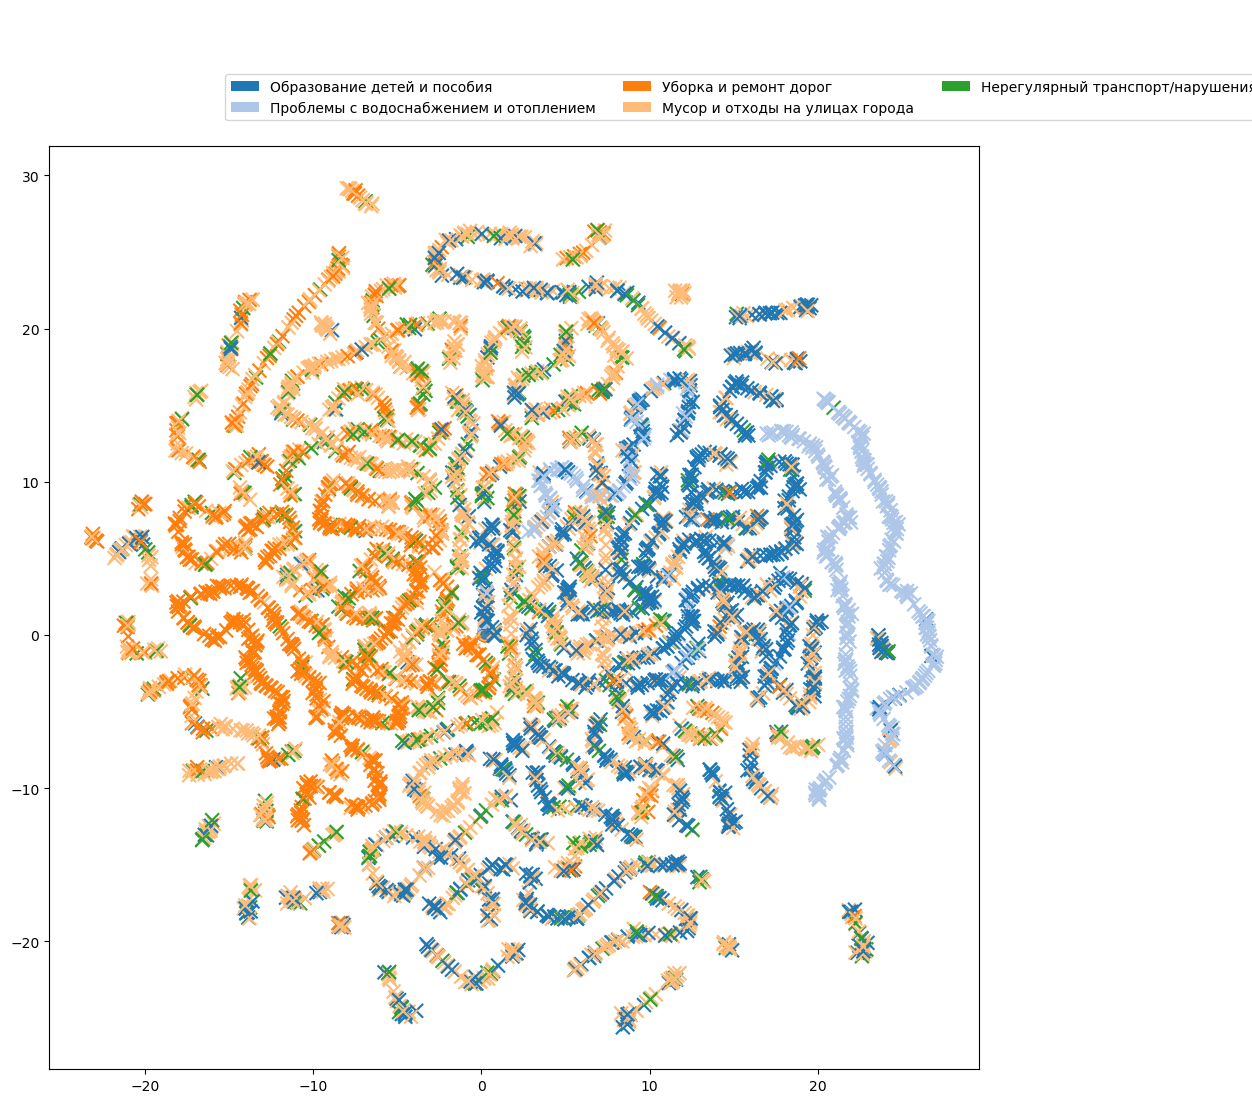

In [61]:
# визуализируем результат
%matplotlib inline

centroids = embedding_umap.values
embedding['hue'] = nmf_embedding.argmax(axis=1)
my_colors = [all_palettes['Category20'][20][i] for i in embedding.hue]

legend_list = []
for color in all_palettes['Category20'][20][:n_topics]:   
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
    
fig,ax = plt.subplots(figsize=(12,13))
ax.scatter(embedding.x, embedding.y, c=my_colors, alpha=0.8)
ax.scatter(centroids[:,0], centroids[:,1], c=my_colors, s=100, alpha=1, marker='x')
fig.legend(legend_list, topics, loc=(0.18,0.89), ncol=3)
plt.subplots_adjust(top=0.82);

Так, получилось 5 тематик жалоб. Из них пересекаются темы, касающиеся уборки мусора и транспорта.

В дальнейшем полученные метки тематик можно будет распространить на весь датафрейм жалоб и вывести категориальную переменную по подтипам сообщений внутри категории "Жалоба". Это обогатит данные, тем самым давая возможность отбирать конкретные сообщения пользователей для более пристального изучения (например, если нас интересует распространенность какой-то тематики как таквой или важна оценка текстовых сообщений, относящихся к какому-то городу)